In [45]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to get the latest block height and metadata
def get_latest_block_info():
    url = "https://textexplore-nextnet.tari.com/?json"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return int(data['tipInfo']['metadata']['best_block_height'])  # Latest block height
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Function to fetch block data for a specific range
def fetch_block_data(start_height, limit):
    url = f"https://textexplore-nextnet.tari.com/?from={start_height}&limit={limit}&json"
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()  # return the data as json
    else:
        raise Exception(f"Failed to fetch data: {response.status_code}")

# Function to parse block data into a pandas dataframe
def parse_block_data(data):
    block_info = []
    
    for block in data['headers']:
        block_info.append({
            "Height": block['height'],
            "Time": block['timestamp'],
            "Proof of Work": block['powText'],
            "Hash": ''.join(format(x, '02x') for x in block['hash']['data']),  # Convert hash buffer to hex string
            "Kernels": block['kernels'],
            "Outputs": block['outputs']
        })
    
    return pd.DataFrame(block_info)



/var/folders/f0/jy_96jds0ns1hjylng2fpkx80000gn/T/ipykernel_87349/3634784167.py:12: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  block_df['Time'] = pd.to_datetime(block_df['Time'], unit='s', errors='coerce')


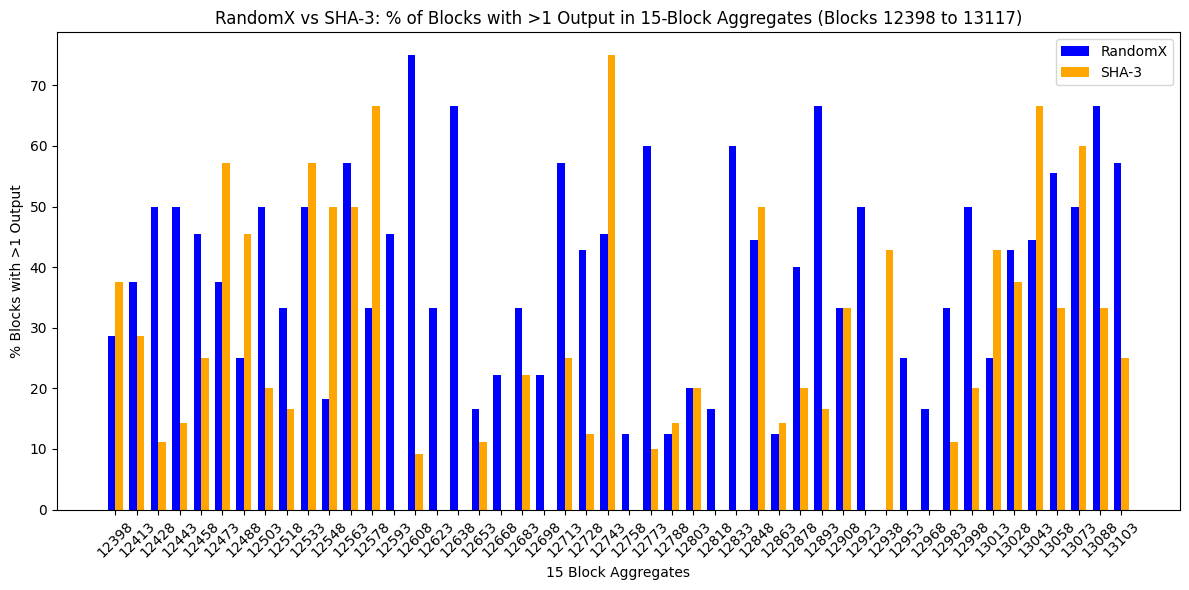

In [46]:
# Fetch the latest 720 blocks, starting from the latest height and working backward
latest_height = get_latest_block_info()

# Fetch exactly the last 720 blocks
limit = 720
start_height = latest_height - limit + 1

block_data = fetch_block_data(start_height, limit)
block_df = parse_block_data(block_data)

# Convert the 'Time' column to datetime and ensure 'Outputs' is numeric
block_df['Time'] = pd.to_datetime(block_df['Time'], unit='s', errors='coerce')
block_df['Outputs'] = pd.to_numeric(block_df['Outputs'], errors='coerce')

# Convert 'Monero' to 'RandomX' in the 'Proof of Work' column
block_df['Proof of Work'] = block_df['Proof of Work'].replace('Monero', 'RandomX')

# Sort blocks in ascending order of height, so the most recent block is at the end
block_df = block_df.sort_values('Height', ascending=True).reset_index(drop=True)

# Function to calculate percentage of blocks with more than one output, in 15-block aggregates
def compute_15_block_aggregates(block_df):
    # Group data in 15-block chunks
    randomx_df = block_df[block_df['Proof of Work'] == 'RandomX']
    sha_df = block_df[block_df['Proof of Work'] == 'SHA-3']
    
    # Aggregate both RandomX and SHA-3 data in 15-block chunks
    randomx_agg = randomx_df.groupby(randomx_df.index // 15).agg({
        'Height': 'first',  # We use the first block height for the aggregate
        'Outputs': lambda x: (x > 1).mean() * 100  # Percentage of blocks with more than 1 output
    }).reset_index(drop=True)
    
    sha_agg = sha_df.groupby(sha_df.index // 15).agg({
        'Height': 'first',  # We use the first block height for the aggregate
        'Outputs': lambda x: (x > 1).mean() * 100  # Percentage of blocks with more than 1 output
    }).reset_index(drop=True)
    
    return randomx_agg, sha_agg

# Compute 15-block aggregates
randomx_agg, sha_agg = compute_15_block_aggregates(block_df)

# Ensure both dataframes have the same length by padding the shorter one with NaN values
max_length = max(len(randomx_agg), len(sha_agg))
randomx_agg = randomx_agg.reindex(range(max_length))
sha_agg = sha_agg.reindex(range(max_length))

# Ensure the heights shown are from start_height to latest_height
randomx_agg['Height'] = randomx_agg['Height'].fillna(sha_agg['Height']).astype(int)
sha_agg['Height'] = sha_agg['Height'].fillna(randomx_agg['Height']).astype(int)

# Plotting the percentage of blocks with >1 output for RandomX and SHA-3 in 15-block aggregates
fig, ax = plt.subplots(figsize=(12, 6))

# Set bar width and x-axis positions for grouped bars
bar_width = 0.35
bar1_positions = np.arange(max_length)
bar2_positions = bar1_positions + bar_width

# Plot RandomX bars
ax.bar(bar1_positions, randomx_agg['Outputs'], color='blue', width=bar_width, label='RandomX')

# Plot SHA-3 bars
ax.bar(bar2_positions, sha_agg['Outputs'], color='orange', width=bar_width, label='SHA-3')

# Add labels and titles
ax.set_xlabel('15 Block Aggregates')
ax.set_ylabel('% Blocks with >1 Output')
ax.set_title(f'RandomX vs SHA-3: % of Blocks with >1 Output in 15-Block Aggregates (Blocks {start_height} to {latest_height})')
ax.legend()

# Set x-ticks with block heights, ensuring the correct heights are shown on the x-axis
heights = np.arange(start_height, latest_height + 1, 15)[:max_length]  # Heights every 15 blocks
plt.xticks(bar1_positions + bar_width / 2, heights, rotation=45)

plt.tight_layout()
plt.show()


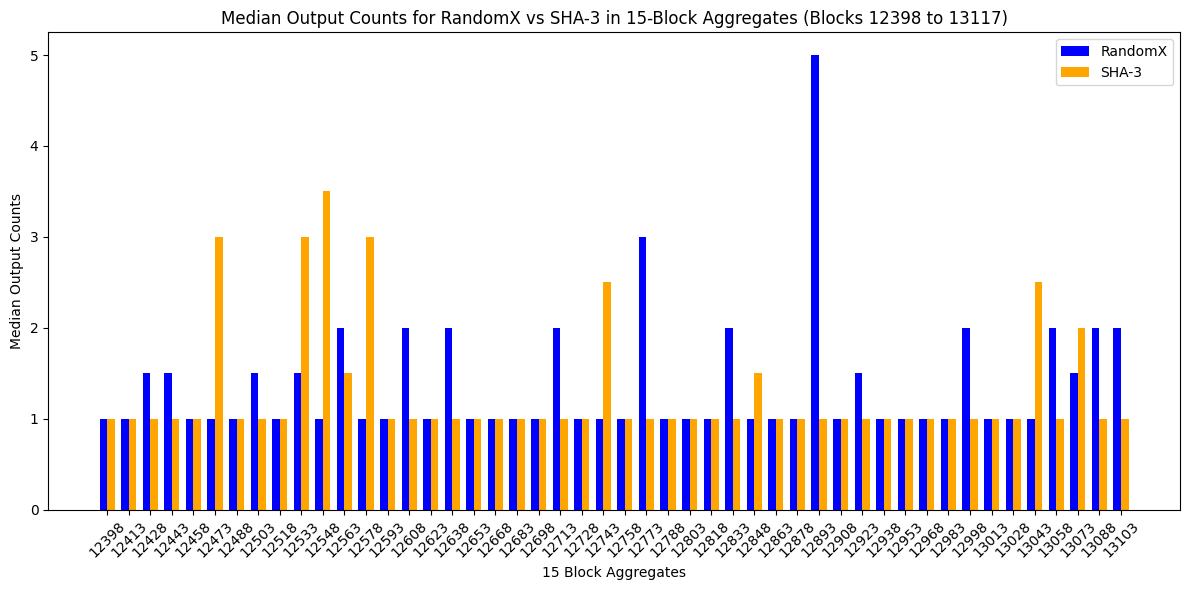

In [47]:
# Function to calculate the median output counts in 15-block aggregates
def compute_median_output_aggregates(block_df):
    # Group data in 15-block chunks
    randomx_df = block_df[block_df['Proof of Work'] == 'RandomX']
    sha_df = block_df[block_df['Proof of Work'] == 'SHA-3']
    
    # Aggregate both RandomX and SHA-3 data in 15-block chunks for median outputs
    randomx_agg = randomx_df.groupby(randomx_df.index // 15).agg({
        'Height': 'first',  # We use the first block height for the aggregate
        'Outputs': 'median'  # Calculate the median of the Outputs
    }).reset_index(drop=True)
    
    sha_agg = sha_df.groupby(sha_df.index // 15).agg({
        'Height': 'first',  # We use the first block height for the aggregate
        'Outputs': 'median'  # Calculate the median of the Outputs
    }).reset_index(drop=True)
    
    return randomx_agg, sha_agg

# Compute the 15-block aggregates for median outputs
randomx_agg, sha_agg = compute_median_output_aggregates(block_df)

# Ensure both dataframes have the same length by padding the shorter one with NaN values
max_length = max(len(randomx_agg), len(sha_agg))
randomx_agg = randomx_agg.reindex(range(max_length))
sha_agg = sha_agg.reindex(range(max_length))

# Ensure the heights shown are from start_height to latest_height
randomx_agg['Height'] = randomx_agg['Height'].fillna(sha_agg['Height']).astype(int)
sha_agg['Height'] = sha_agg['Height'].fillna(randomx_agg['Height']).astype(int)

# Plotting the median output counts for RandomX and SHA-3 in 15-block aggregates
fig, ax = plt.subplots(figsize=(12, 6))

# Set bar width and x-axis positions for grouped bars
bar_width = 0.35
bar1_positions = np.arange(max_length)
bar2_positions = bar1_positions + bar_width

# Plot RandomX bars
ax.bar(bar1_positions, randomx_agg['Outputs'], color='blue', width=bar_width, label='RandomX')

# Plot SHA-3 bars
ax.bar(bar2_positions, sha_agg['Outputs'], color='orange', width=bar_width, label='SHA-3')

# Add labels and titles
ax.set_xlabel('15 Block Aggregates')
ax.set_ylabel('Median Output Counts')
ax.set_title(f'Median Output Counts for RandomX vs SHA-3 in 15-Block Aggregates (Blocks {start_height} to {latest_height})')
ax.legend()

# Set x-ticks with block heights, ensuring the correct heights are shown on the x-axis
heights = np.arange(start_height, latest_height + 1, 15)[:max_length]  # Heights every 15 blocks
plt.xticks(bar1_positions + bar_width / 2, heights, rotation=45)

plt.tight_layout()
plt.show()


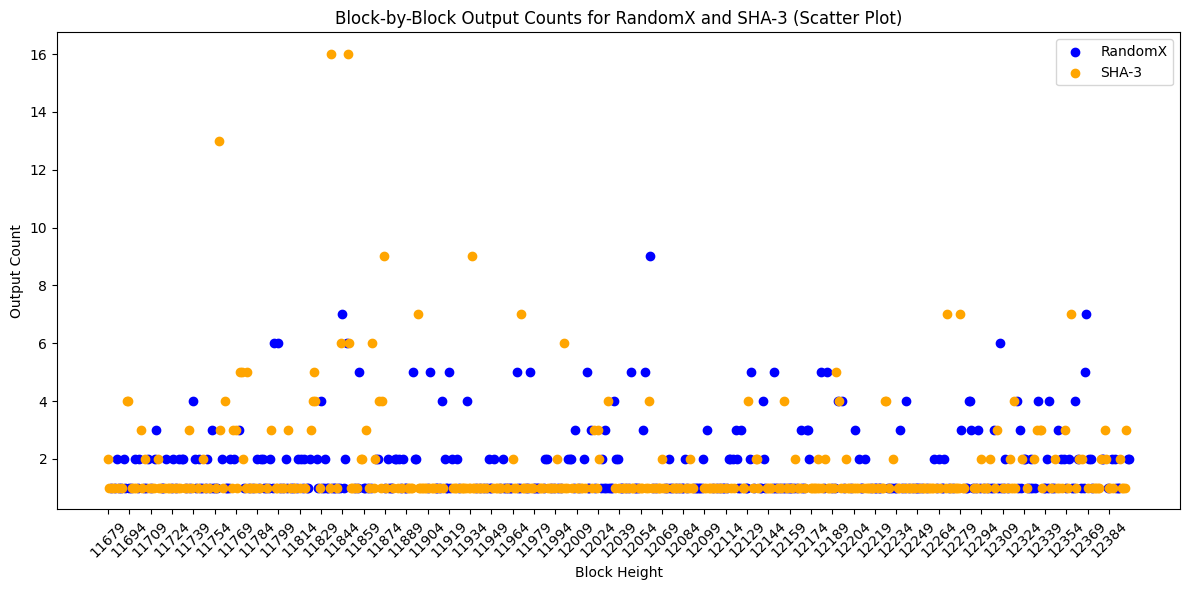

In [48]:
# Plot the block-by-block outputs for each PoW type on a contiguous block height x-axis, using a scatter plot
def plot_block_by_block_outputs_scatter(block_df):
    # Filter the data for each PoW type
    randomx_df = block_df[block_df['Proof of Work'] == 'RandomX']
    sha_df = block_df[block_df['Proof of Work'] == 'SHA-3']
    
    # Merge the two datasets by block height to ensure they have the same x-axis range
    combined_df = pd.merge(randomx_df[['Height', 'Outputs']], sha_df[['Height', 'Outputs']], on='Height', how='outer', suffixes=('_RandomX', '_SHA3')).sort_values('Height')
    
    # Set up figure and axis for the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot RandomX as scatter
    ax.scatter(combined_df['Height'], combined_df['Outputs_RandomX'], color='blue', label='RandomX')
    
    # Plot SHA-3 as scatter
    ax.scatter(combined_df['Height'], combined_df['Outputs_SHA3'], color='orange', label='SHA-3')

    # Add labels and titles
    ax.set_xlabel('Block Height')
    ax.set_ylabel('Output Count')
    ax.set_title('Block-by-Block Output Counts for RandomX and SHA-3 (Scatter Plot)')
    ax.legend()
    
    # Reduce x-axis label density: show every 15th block height
    step_size = 15
    ax.set_xticks(combined_df['Height'][::step_size])
    ax.set_xticklabels(combined_df['Height'][::step_size], rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()

# Call the function to plot the block-by-block outputs as a scatter plot
plot_block_by_block_outputs_scatter(block_df)







In [49]:
import base58
from hashlib import blake2b
import pandas as pd
# Function to generate a blake2b hash with 20-byte output and base58 encoding
def blake2b_base58(input_string):
    hasher = blake2b(digest_size=20)
    hasher.update(input_string.encode('utf-8'))
    hashed_bytes = hasher.digest()
    return base58.b58encode(hashed_bytes)



# Load the data
df = pd.read_csv('~/Downloads/app_mining.csv')

# Apply the new hashing function to the app_id column
df['app_id_hashed'] = df['app_id'].apply(blake2b_base58)

# Save or display the updated dataframe
df.to_csv('~/Downloads/app_mining_with_hashed_ids.csv', index=False)


In [50]:
# Convert 'dt' columns to datetime in both datasets for analysis

# Load the CSV file to inspect its content
file_path = '~/Downloads/app_mining_with_hashed_ids.csv'
mining_data = pd.read_csv(file_path)

# Display the first few rows to understand the structure of the data
print(mining_data.head())

# Load the second file (p2pool_wins.csv) to inspect its content
p2pool_wins_path = '~/Downloads/p2pool_wins.csv'
p2pool_wins_data = pd.read_csv(p2pool_wins_path)

# Display the first few rows of the second dataset to understand its structure
p2pool_wins_data.head()

mining_data['dt'] = pd.to_datetime(mining_data['dt'])
p2pool_wins_data['dt'] = pd.to_datetime(p2pool_wins_data['dt'])

# Filter the data to include only events within a 24-hour window from the earliest timestamp in both datasets
mining_start_time = mining_data['dt'].min()
wins_start_time = p2pool_wins_data['dt'].min()

# Find the common 24-hour period across both datasets
start_time = max(mining_start_time, wins_start_time)
end_time = start_time + pd.Timedelta(hours=24)

# Filter both datasets to the 24-hour period
mining_filtered = mining_data[(mining_data['dt'] >= start_time) & (mining_data['dt'] < end_time)]
p2pool_wins_filtered = p2pool_wins_data[(p2pool_wins_data['dt'] >= start_time) & (p2pool_wins_data['dt'] < end_time)]

# Find the unique hashed IDs in the p2pool wins data
unique_winners = p2pool_wins_filtered['unique_id_hashed'].unique()

# Find how many unique app_id_hashed won anything
unique_mining_wins = mining_filtered[mining_filtered['app_id_hashed'].isin(unique_winners)]['app_id_hashed'].nunique()

unique_mining_wins

                            dt                app_id  \
0  September 25, 2024, 7:11 PM  ^awfEmKkj^Dh4vdfxPau   
1  September 25, 2024, 8:52 PM  t8@oM4k8Mt440##zP8Qc   
2  September 25, 2024, 9:14 PM  ^awfEmKkj^Dh4vdfxPau   
3  September 25, 2024, 9:41 PM  t8@oM4k8Mt440##zP8Qc   
4  September 26, 2024, 1:41 AM  oiW#&%H0T@0tOMXH&Bfd   

                     app_id_hashed  
0  b'2BoRpNR6PfB3mU6e7ogpG1DZMrU4'  
1   b'3naa7uEXYfD4UWTCFKdumqi1SFr'  
2  b'2BoRpNR6PfB3mU6e7ogpG1DZMrU4'  
3   b'3naa7uEXYfD4UWTCFKdumqi1SFr'  
4  b'37gtGGWfv3QzNU8QXUPCz6t37T3H'  


/var/folders/f0/jy_96jds0ns1hjylng2fpkx80000gn/T/ipykernel_87349/1007318785.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  mining_data['dt'] = pd.to_datetime(mining_data['dt'])
/var/folders/f0/jy_96jds0ns1hjylng2fpkx80000gn/T/ipykernel_87349/1007318785.py:18: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  p2pool_wins_data['dt'] = pd.to_datetime(p2pool_wins_data['dt'])


0